In [14]:
import os
import yaml
from glob import glob
from tqdm import tqdm
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import make_lupton_rgb

from mejiro.synthetic_image import SyntheticImage
from mejiro.exposure import Exposure
from mejiro.instruments.hst import HST
from mejiro.instruments.roman import Roman
from mejiro.instruments.lsst import LSST
from mejiro.instruments.hwo import HWO
from mejiro.utils import util

# read configuration file
with open('/grad/bwedig/mejiro/projects/pipeline/hwo.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

Warning, 5 of 20000 bins contained negative fluxes; they have been set to zero.


/data/bwedig/.conda/envs/mejiro-v2/lib/python3.10/site-packages/pysynphot/units.py:824: RuntimeWarning: divide by zero encountered in log
  return -1.085736 * N.log(arg) + ABZERO


Warning, 3590 of 20000 bins contained negative fluxes; they have been set to zero.
Warning, 293 of 2920 bins contained negative fluxes; they have been set to zero.


In [2]:
if config['dev']:
    config['pipeline_label'] += '_dev'

In [3]:
lenses = util.unpickle_all(os.path.join(config['data_dir'], config['pipeline_label'], '02'))
print(f'Found {len(lenses)} strong lens(es)')

Found 7 strong lens(es)


In [4]:
sample = lenses[0]
pprint(sample.physical_params['magnitudes'])

{'lens': {'B': 26.794025854230917,
          'F062': 26.240413197624584,
          'F087': 24.311617926997314,
          'F106': 23.17519907534156,
          'F129': 22.16097265678249,
          'F146': 21.920372062066605,
          'F158': 21.577384512960506,
          'F184': 21.28502901193412,
          'F213': 21.011312688034245,
          'F438W': 26.890180067312144,
          'F475W': 26.779709140264053,
          'F606W': 26.46018617696665,
          'F814W': 24.840870103957272,
          'FUV': 29.352266807586275,
          'H': 21.551155699261095,
          'I': 24.49804889463139,
          'J': 22.224530806611163,
          'K': 20.960354808825606,
          'NUV': 27.41426203224406,
          'R': 25.185100209156346,
          'U': 26.958963716772182,
          'V': 26.402682866227018,
          'g': 26.774693174474137,
          'i': 25.419446617096334,
          'r': 26.368703754987273,
          'u': 26.83996921518426,
          'y': 23.77724107264146,
          'z': 24.3

Scene size: 5.001921551492087 arcsec, 291 pixels at pixel scale 0.017188733853924696 arcsec/pix


/grad/bwedig/mejiro/mejiro/synthetic_image.py:252: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(self.image), origin='lower')


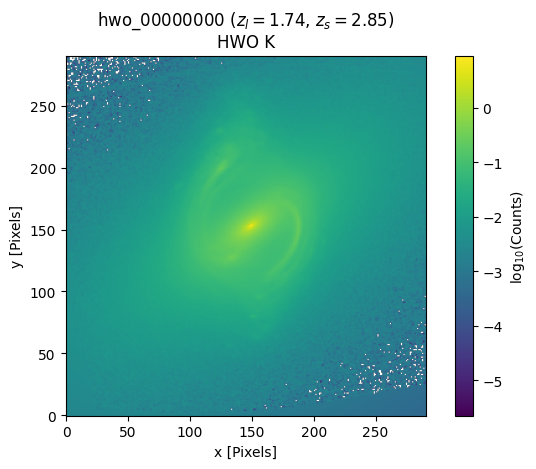

In [15]:
synthetic_image_hwo = SyntheticImage(strong_lens=sample,
                                     instrument=HWO(),
                                     band='K',
                                     verbose=True)
synthetic_image_hwo.plot()

Scene size: 5.04 arcsec, 63 pixels at pixel scale 0.08 arcsec/pix


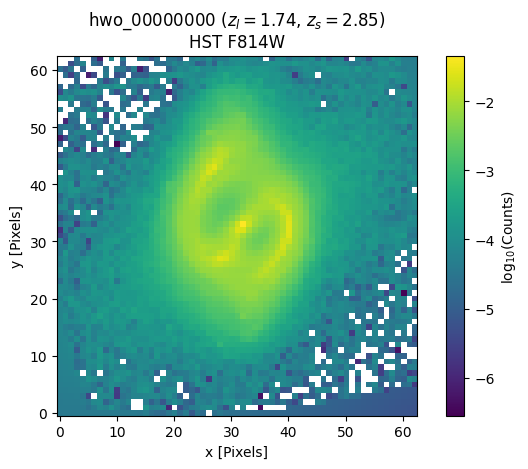

In [18]:
synthetic_image_hst = SyntheticImage(strong_lens=sample,
                                 instrument=HST(),
                                 band='F814W',
                                 verbose=True)
synthetic_image_hst.plot()

Scene size: 5.17 arcsec, 47 pixels at pixel scale 0.11 arcsec/pix


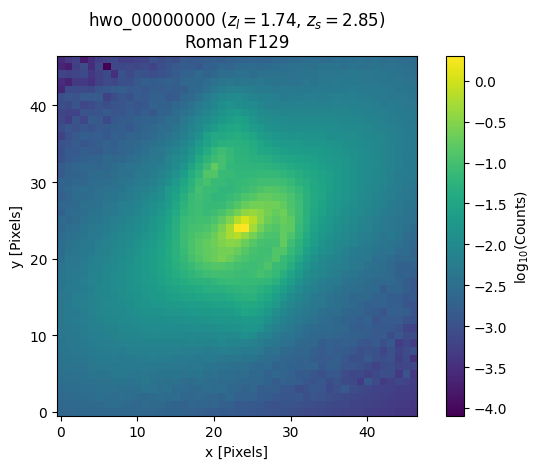

In [6]:
synthetic_image_roman = SyntheticImage(strong_lens=sample,
                                 instrument=Roman(),
                                 band='F129',
                                 verbose=True)
synthetic_image_roman.plot()

Scene size: 5.0 arcsec, 25 pixels at pixel scale 0.2 arcsec/pix


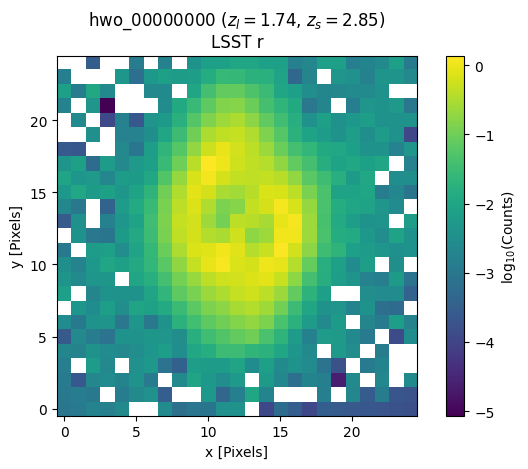

In [7]:
synthetic_image_lsst = SyntheticImage(strong_lens=sample,
                                 instrument=LSST(),
                                 band='r',
                                 verbose=True)
synthetic_image_lsst.plot()

Exposure calculation time with galsim engine: 0.029 s


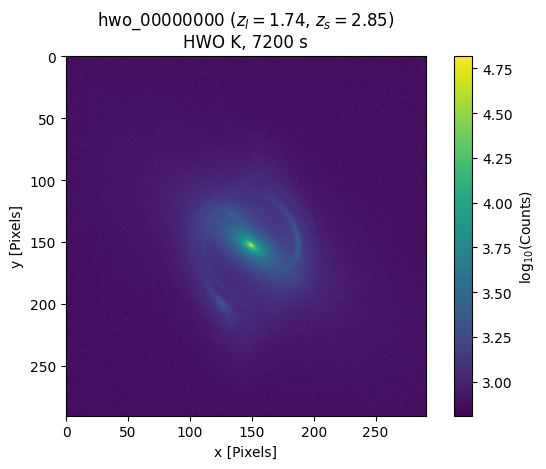

In [20]:
exposure_hwo = Exposure(synthetic_image=synthetic_image_hwo,
                        exposure_time=7200,
                        # engine='lenstronomy',
                        verbose=True)
exposure_hwo.plot()

Exposure calculation time with lenstronomy engine: 0.022 s


/data/bwedig/.conda/envs/mejiro-v2/lib/python3.10/site-packages/lenstronomy/LensModel/MultiPlane/multi_plane.py:77: UserWarning: Cosmology is provided. Make sure your cosmological model is consistent with the cosmology_model argument.
  warnings.warn(
/grad/bwedig/mejiro/mejiro/utils/util.py:170: UserWarning: Negative values in array have been replaced with 5.747386910852706e-06.
  warnings.warn(f"Negative values in array have been replaced with {replacement}.")


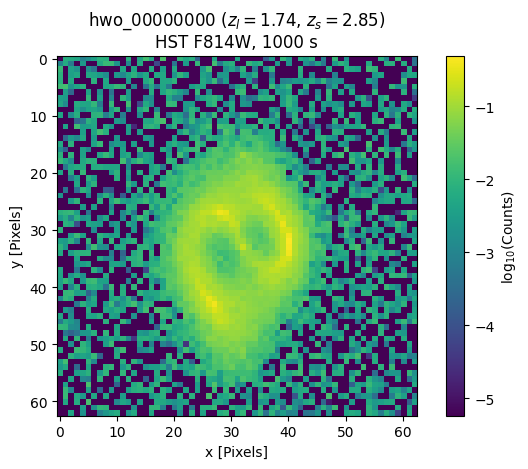

In [8]:
exposure_hst = Exposure(synthetic_image=synthetic_image_hst,
                    exposure_time=1000,
                    engine='lenstronomy',
                    verbose=True)
exposure_hst.plot()

/grad/bwedig/mejiro/mejiro/utils/util.py:170: UserWarning: Negative values in array have been replaced with 6.480291659180558e-05.
  warnings.warn(f"Negative values in array have been replaced with {replacement}.")


Exposure calculation time with lenstronomy engine: 0.04 s


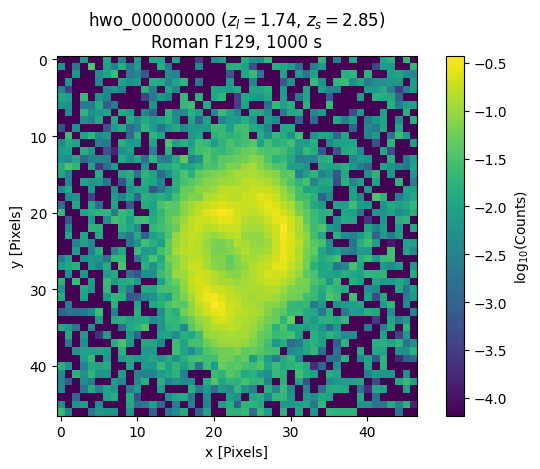

In [9]:
exposure_roman = Exposure(synthetic_image=synthetic_image_roman,
                    exposure_time=1000,
                    engine='lenstronomy',
                    verbose=True)
exposure_roman.plot()

/grad/bwedig/mejiro/mejiro/utils/util.py:170: UserWarning: Negative values in array have been replaced with 0.00034941404749304263.
  warnings.warn(f"Negative values in array have been replaced with {replacement}.")


Exposure calculation time with lenstronomy engine: 0.015 s


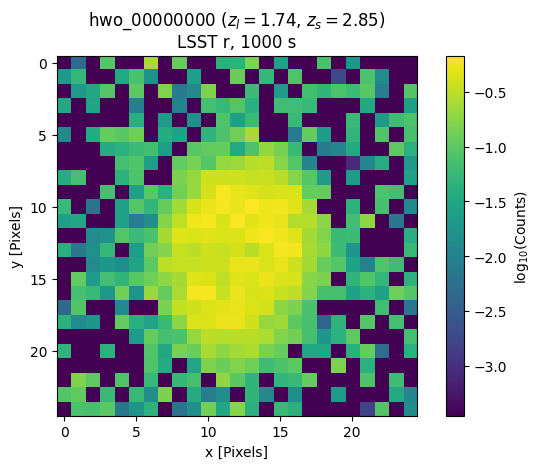

In [10]:
exposure_lsst = Exposure(synthetic_image=synthetic_image_lsst,
                    exposure_time=1000,
                    engine='lenstronomy',
                    verbose=True)
exposure_lsst.plot()

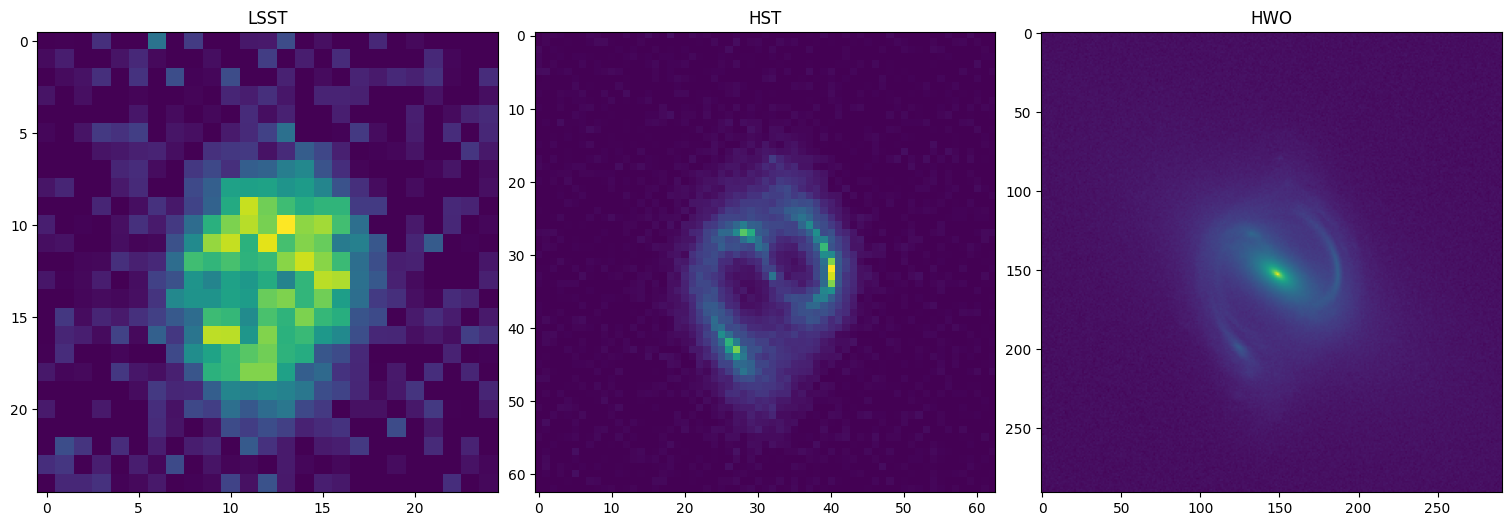

In [24]:
f, ax = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
ax[0].imshow(exposure_lsst.exposure)
ax[0].set_title('LSST')
ax[1].imshow(exposure_hst.exposure)
ax[1].set_title('HST')
ax[2].imshow(np.log10(exposure_hwo.exposure))
ax[2].set_title('HWO')
plt.show()